This notebook is for experimenting with ```new parts``` in the main  notebook file
## Natural Pandemics
1. spot errors in the plot file & computed_gpd function
2. reproduce maximum likelihood estimation for gpd model
3. calculate standard error and tired CI
4. goodness of fit tests

In [1]:
from helpers import *
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
params = Params()

In [3]:
marani_xls = params.Natural.dataset.val
marani_df, disease_totals = load_and_preprocess_natural_data(marani_xls)

In [4]:
# drop the row with NaN
marani_df = marani_df.dropna(subset=["Intensity (deaths per thousand/year)"])
marani_df["Intensity (deaths per thousand/year)"].isna().sum()

0

In [5]:
marani_1e_5_df = marani_df[(marani_df["Intensity (deaths per thousand/year)"] > 1e-5) & (marani_df["Start Year"].between(1600, 1944))]

In [6]:
sorted_data = marani_df.sort_values(by='Intensity (deaths per thousand/year)', ascending=True)
exceedance_probs = 1 - np.arange(len(sorted_data)) / len(sorted_data)
sorted_data["Exceedance Probability"] = exceedance_probs

In [7]:
mu = params.Natural.mu.val
sigma = params.Natural.sigma.val
xi = params.Natural.xi.val
print(f'paramters from original paper: mu={mu}, sigma={sigma}, xi={xi}')
gpd_vals = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=mu, sigma=sigma, xi=xi)
sorted_data["GPD"] = gpd_vals

paramters from original paper: mu=0.001, sigma=0.0113, xi=1.4


In [8]:
sorted_data["GPD"]

399    1.000000
432    1.000000
431    1.000000
412    1.000000
81     1.000000
         ...   
330    0.025773
181    0.020832
24     0.010079
392    0.009226
11     0.007949
Name: GPD, Length: 383, dtype: float64

In [9]:
np.log(sorted_data["Exceedance Probability"])

399    0.000000
432   -0.002614
431   -0.005236
412   -0.007864
81    -0.010499
         ...   
330   -4.338597
181   -4.561741
24    -4.849423
392   -5.254888
11    -5.948035
Name: Exceedance Probability, Length: 383, dtype: float64

In [10]:
np.log(sorted_data["GPD"]*0.62)

399   -0.478036
432   -0.478036
431   -0.478036
412   -0.478036
81    -0.478036
         ...   
330   -4.136453
181   -4.349281
24    -5.075311
392   -5.163813
11    -5.312763
Name: GPD, Length: 383, dtype: float64

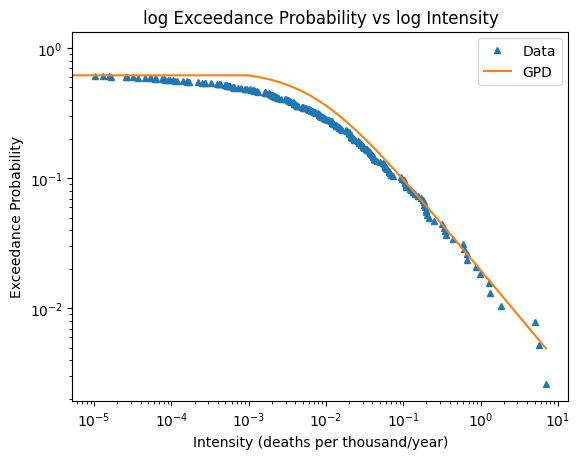

In [11]:
#draw log-log scale plot
fig, ax = plt.subplots()
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["Exceedance Probability"], '^', markersize=4)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["GPD"]*0.62)
# cut x at 0.001
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data", "GPD"])
ax.set_title("log Exceedance Probability vs log Intensity")
plt.show()

**Data used to fit the model is the ones > 0.001**

In [12]:
x = "Intensity (deaths per thousand/year)"
intensities = np.linspace(marani_df[x].min(), marani_df[x].max(), 1000)

In [13]:
marani_1e_3_df = marani_df[(marani_df["Intensity (deaths per thousand/year)"] > 1e-3) & (marani_df["Start Year"].between(1600, 1944))]

In [14]:
from scipy.stats import genpareto
# fit GPD with mu = 0.001
xi, mu, sigma = genpareto.fit(data = marani_1e_3_df[x],floc=0.001) # floc=0.001 is the location parameter
print(f'fitted parameters: mu={mu}, sigma={sigma}, xi={xi}') # agree with the original paper

fitted parameters: mu=0.001, sigma=0.01129066673666155, xi=1.3980986273217102


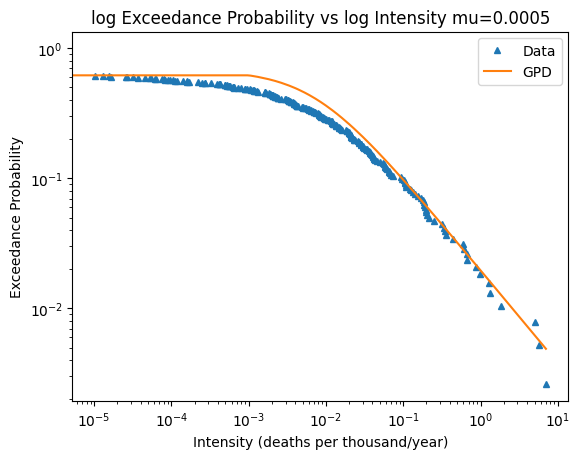

In [15]:
#draw log-log scale plot
gpd_vals = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=mu, sigma=sigma, xi=xi)
sorted_data["GPD"] = gpd_vals
fig, ax = plt.subplots()
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["Exceedance Probability"], '^', markersize=4)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["GPD"]*0.62)
# cut x at 0.001
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data", "GPD"])
ax.set_title("log Exceedance Probability vs log Intensity mu=0.0005")
plt.show()

In [16]:
import numpy as np
from scipy.stats import genpareto
from scipy.optimize import minimize
import statsmodels.api as sm

# Generate some sample data from a GPD distribution
# Generate some sample data from a GPD distribution
np.random.seed(0)
data = marani_1e_3_df[x]

def neg_log_likelihood(params, data):
    scale, shape = params
    threshold = 0.001  # Fixed location parameter
    if shape == 0:
        return np.inf  # Avoid division by zero
    return -np.sum(genpareto.logpdf(data, shape, loc=threshold, scale=scale))

# Initial parameter guesses
initial_guess = (1, 0.5)

# Perform maximum likelihood estimation
result = minimize(neg_log_likelihood, initial_guess, args=(data,), method='Nelder-Mead')
scale_mle, shape_mle = result.x

# Compute Hessian matrix
def hessian(func, params, args):
    def get_gradient(func, params, args, epsilon=1e-5):
        grad = []
        for i in range(len(params)):
            params_plus = params.copy()
            params_plus[i] += epsilon
            grad.append((func(params_plus, *args) - func(params, *args)) / epsilon)
        return grad
    grad = get_gradient(func, params, args)
    hess = []
    for i in range(len(params)):
        params_plus = params.copy()
        params_plus[i] += 1e-4 * params_plus[i]
        grad_plus = get_gradient(func, params_plus, args)
        hess.append([(grad_plus[j] - grad[j]) / (1e-4 * params_plus[i]) for j in range(len(grad))])
    return np.array(hess)

hess = hessian(neg_log_likelihood, result.x, (data,))

# Compute standard errors
covariance_matrix = np.linalg.inv(hess)
scale_se, shape_se = np.sqrt(np.diagonal(covariance_matrix))

# Print MLE results and standard errors
print("Maximum Likelihood Estimation (MLE) Results:")
print("Threshold (Location) Parameter: 0.001 (fixed)")
print("Scale MLE:", scale_mle)
print("Shape MLE:", shape_mle)
print("\nStandard Errors:")
print("Scale SE:", scale_se)
print("Shape SE:", shape_se)

# Fit GPD using statsmodels
gpd_model = sm.GLM(data, sm.add_constant(np.where(data > 0.001, data - 0.001, 0)), 
                   family=sm.families.Gamma(sm.families.links.identity()))
gpd_result = gpd_model.fit()

# Print statsmodels summary
print("\nStatsmodels GLM Summary:")
print(gpd_result.summary())

Maximum Likelihood Estimation (MLE) Results:
Threshold (Location) Parameter: 0.001 (fixed)
Scale MLE: 0.011290005748011766
Shape MLE: 1.3981001450194226

Standard Errors:
Scale SE: 0.002077411213233193
Shape SE: 0.20035283862125017

Statsmodels GLM Summary:
                          Generalized Linear Model Regression Results                           
Dep. Variable:     Intensity (deaths per thousand/year)   No. Observations:                  151
Model:                                              GLM   Df Residuals:                      149
Model Family:                                     Gamma   Df Model:                            1
Link Function:                                 identity   Scale:                      2.0520e-31
Method:                                            IRLS   Log-Likelihood:                 0.0000
Date:                                  Sat, 17 Feb 2024   Deviance:                  -2.1386e-15
Time:                                          16:08:00   Pears

d:\appfiles\anaconda\envs\dis\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
d:\appfiles\anaconda\envs\dis\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\appfiles\anaconda\envs\dis\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
d:\appfiles\anaconda\envs\dis\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, ca

In [17]:
from new_helpers import *
# Fit GPD using statsmodels
x = "Intensity (deaths per thousand/year)"
data = marani_1e_3_df[x]
gpd_results = find_gpd_mle(data, threshold = 0.001, find_std = True, return_nll = True)

In [18]:
covariance_matrix, scale_mle, shape_mle, scale_se, shape_se, minimized_nll = gpd_results

### Confidence Intervals
- Appendix of Marani et al.: Lines indicate the 95% confidence interval for the frequency values, computed according to **Wilson’s score** (not tried yet)
- My thought: MLE with errors, can directly calculate CI

In [19]:
# calculate the 95% confidence region for the GPD
from scipy.stats import chi2
alpha = 0.05
df = 2  # Degrees of freedom
chi2_critical = chi2.ppf(1 - alpha / 2, df)
covariance_matrix = np.linalg.inv(hess)
scale_mle, shape_mle = result.x
scale_se, shape_se = np.sqrt(np.diagonal(covariance_matrix))
scale_lower = scale_mle - np.sqrt(chi2_critical) * scale_se
scale_upper = scale_mle + np.sqrt(chi2_critical) * scale_se
shape_lower = shape_mle - np.sqrt(chi2_critical) * shape_se
shape_upper = shape_mle + np.sqrt(chi2_critical) * shape_se
print("95% Confidence Region for GPD Parameters:")
print("Scale:", (scale_lower, scale_upper))
print("Shape:", (shape_lower, shape_upper))

95% Confidence Region for GPD Parameters:
Scale: (0.005647335112994649, 0.016932676383028884)
Shape: (0.8539011573905115, 1.9422991326483336)


In [20]:
import numpy as np
from scipy.stats import multivariate_normal as mvn

dist = mvn( mean=[scale_mle,shape_se], cov=covariance_matrix )


xlim = (-0.0,0.02)
ylim = (-0.5,1)
  
x = np.linspace(*xlim,1000)
y = np.linspace(*ylim,1000)

X, Y = np.meshgrid(x,y)
pos = np.dstack( (X,Y) )
Z = dist.pdf(pos)

Text(0.5, 1.0, 'approximate distribution of estimates of GPD parameters')

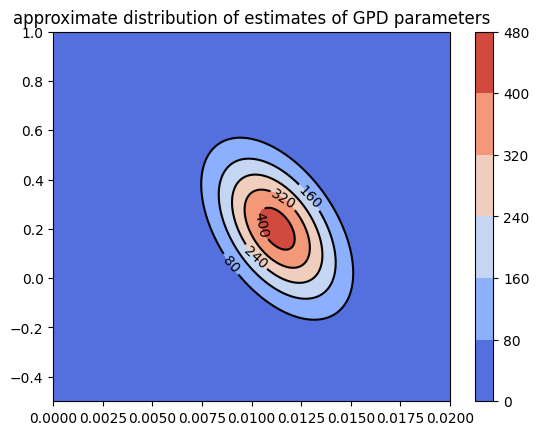

In [21]:
# for illustration purposes
fig, ax = plt.subplots()
im = ax.contourf(X,Y,Z,levels=5,cmap='coolwarm')
cs = ax.contour(X,Y,Z,levels = 5, colors='k')
plt.clabel(cs, cs.levels, inline=True)
plt.colorbar(im)
plt.title('approximate distribution of estimates of GPD parameters')

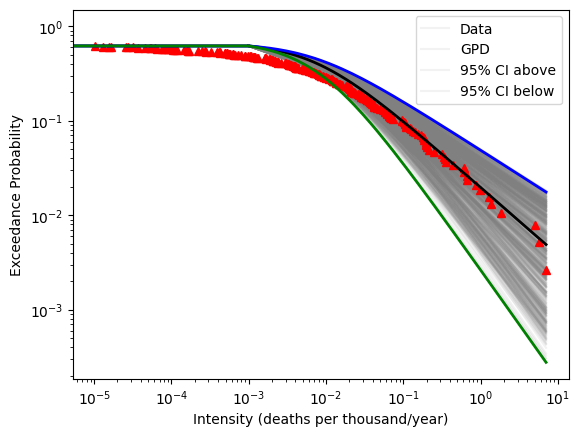

In [22]:
fig, ax = plt.subplots()

# plot 95% confidence region (2D) for the fitted GPD
# parameteric sampling samples from the fitted distribution
n_samples = 1000
n_simulations = 1000
x = "Intensity (deaths per thousand/year)"
distance_above = 0
distance_below = 0
gdp_mle = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=0.001, sigma=scale_mle, xi=shape_mle)
for simulation in range(n_simulations):
    # random parameters in the 95% confidence region (parobolic region)
    scale_samples = np.random.uniform(scale_lower, scale_upper)
    shape_samples = np.random.uniform(shape_lower, shape_upper)
    # discard if the cdf is less than 0.025 or greater than 0.975
    if dist.cdf([scale_samples, shape_samples]) < 0.025 or dist.cdf([scale_samples, shape_samples]) > 0.975:
        continue
    intensities = np.linspace(marani_df[x].min(), marani_df[x].max(),n_samples) 
    # setting the intensities less then 0.001 to 0.001
    intensities = np.where(intensities > 0.001, intensities, 0.001)
    gpd = compute_gpd(x=intensities, mu=0.001, sigma=scale_samples, xi=shape_samples)
    # find the line furtherest from the mle line
    # for gpd_vals larger than gpd_mle, find the PARAMETERS give largest difference
    # for gpd_vals smaller than gpd_mle, find the PARAMETERS give largest difference
    gpd_vals = compute_gpd(x=sorted_data["Intensity (deaths per thousand/year)"], mu=0.001, sigma=scale_samples, xi=shape_samples)
    if np.max(gpd_vals - gdp_mle) > distance_above:
        distance_above = np.max(gpd_vals - gdp_mle)
        scale_above = scale_samples
        shape_above = shape_samples
        pd_vals_above = gpd_vals
    if np.max(gdp_mle - gpd_vals) > distance_below:
        distance_below = np.max(gdp_mle - gpd_vals)
        scale_below = scale_samples
        shape_below = shape_samples
        pd_vals_below = gpd_vals
    ax.plot(intensities, gpd * 0.62, color='gray', alpha=0.1)    

ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["Exceedance Probability"], '^', markersize=6, color='red')
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], sorted_data["GPD"]*0.62, color='black', linewidth=2)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], pd_vals_above * 0.62, color='blue', linewidth=2)
ax.plot(sorted_data["Intensity (deaths per thousand/year)"], pd_vals_below * 0.62, color='green', linewidth=2)
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data", "GPD", "95% CI above", "95% CI below"])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [23]:
import plotly.graph_objects as go
import plotly.express as px
# plot the 95% confidence region (2D) for the fitted GPD
fig = go.Figure()
fig.add_trace(go.Scatter(x=sorted_data["Intensity (deaths per thousand/year)"], y=sorted_data["Exceedance Probability"], 
                         mode='markers', name='Data', marker=dict(size=8, color='gray', opacity=0.5)))
fig.add_trace(go.Scatter(x=sorted_data["Intensity (deaths per thousand/year)"], y=sorted_data["GPD"]*0.62, 
                         mode='lines', name='GPD model', line=dict(color='black', width=2)))    
fig.add_trace(go.Scatter(x=sorted_data["Intensity (deaths per thousand/year)"], y=pd_vals_above*0.62, 
                         mode='lines', name='95% CI above', line=dict(color='blue', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=sorted_data["Intensity (deaths per thousand/year)"], y=pd_vals_below*0.62, 
                         mode='lines', name='95% CI below', line=dict(color='green', width=2, dash='dash')))
fig.update_layout(title='95% Confidence Region for GPD Parameters',
                   xaxis_title='Intensity (deaths per thousand/year)',
                   yaxis_title='Exceedance Probability',
                   xaxis_type="log",
                   yaxis_type="log")
fig.show()

In [24]:
print(f'95% CI above: scale={scale_above}, shape={shape_above}')
print(f'95% CI below: scale={scale_below}, shape={shape_below}')

95% CI above: scale=0.015013010136786773, shape=1.9077821258244896
95% CI below: scale=0.007747877560710818, shape=0.8639666555787819


1. try wilson's theorem
2. using plotly
3. def a function find CI (method, plot=True, return params=True...)

In [25]:
import scipy.stats as stats
import math

def wilson_score_interval(x, n, confidence=0.95):
    """
    Calculate the Wilson score interval for a binomial proportion.

    Parameters:
        x (int): Number of successes.
        n (int): Sample size.
        confidence (float): Confidence level (default is 0.95 for 95% confidence).

    Returns:
        tuple: Lower and upper bounds of the confidence interval.
    """
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    p_hat = x / n
    lower_bound = (p_hat + (z**2) / (2 * n) - z * math.sqrt((p_hat * (1 - p_hat) + (z**2) / (4 * n)) / n)) / (1 + (z**2) / n)
    upper_bound = (p_hat + (z**2) / (2 * n) + z * math.sqrt((p_hat * (1 - p_hat) + (z**2) / (4 * n)) / n)) / (1 + (z**2) / n)
    return lower_bound, upper_bound

wilson_score_interval = np.vectorize(wilson_score_interval)
# Example usage:
x = 60  # Number of successes
n = 100  # Sample size
confidence = 0.95  # Confidence level

lower, upper = wilson_score_interval(x, n, confidence)
print(f"Wilson's confidence interval at {confidence*100}% confidence: [{lower}, {upper}]")

Wilson's confidence interval at 95.0% confidence: [0.5020025867910617, 0.6905987135675411]


In [26]:
# compute 95% confidence interval for the exceedance probability for a given intensity
n = len(marani_1e_5_df)
confidence = 0.95
exceedance_probs = marani_1e_5_df["Exceedance Probability"]
lowers, uppers = wilson_score_interval(exceedance_probs * n, n, confidence)

In [27]:
wilson_df = pd.DataFrame({'intensity': marani_1e_5_df['Intensity (deaths per thousand/year)'],'exceedance_probs': exceedance_probs, 'lowers': lowers, 'uppers': uppers})
wilson_df = wilson_df.sort_values(by='intensity', ascending=True)
wilson_df = wilson_df.reset_index(drop=True)
wilson_df.head()

,intensity,exceedance_probs,lowers,uppers
0,0.000010,0.614583,0.542201,0.682228
1,0.000016,0.606771,0.534301,0.674827
2,0.000027,0.601562,0.529044,0.669882
3,0.000046,0.593750,0.521174,0.662450
4,0.000054,0.588542,0.515937,0.657485


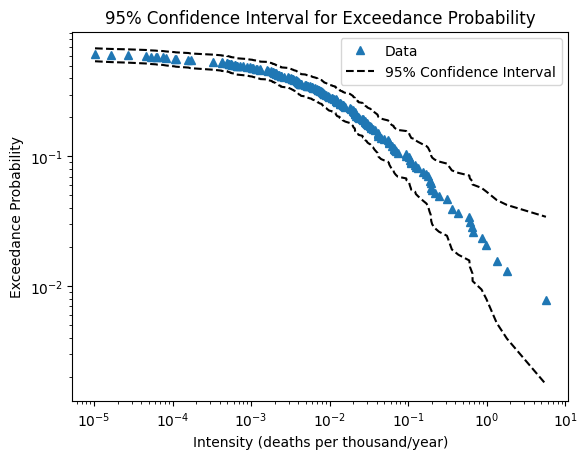

In [28]:
# line plot of lower and upper bounds of the 95% confidence interval
fig, ax = plt.subplots()
ax.plot(wilson_df['intensity'], wilson_df['exceedance_probs'], '^', markersize=6)
ax.plot(wilson_df['intensity'], wilson_df['lowers'], color='black', linestyle='dashed')
ax.plot(wilson_df['intensity'], wilson_df['uppers'], color='black', linestyle='dashed')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Intensity (deaths per thousand/year)")
ax.set_ylabel("Exceedance Probability")
ax.legend(["Data", "95% Confidence Interval"])
ax.set_title("95% Confidence Interval for Exceedance Probability")
plt.show()

The problem here is if we want to integrate the lower or upper values with cutting at 17.8 we can not find the exact value for doing so.

#### Chi-squared test
Note: the location parameter is chosen before maximum likelihood fit
$$
\text{degree\_of\_freedom} = \text{number\_of\_bins} - \text{number\_of\_free parameters}(2)
$$

In [29]:
# chi-squared test
import scipy.stats as stats
observed = sorted_data["Exceedance Probability"]
# expected data is concatinated from 0.62*GPD and 0.38 (for intensity < 0.001)
expected = 0.62*sorted_data["GPD"]
# we now need to bin the data
bins = np.linspace(0, 1, 21) # 20 bins
observed_counts, _ = np.histogram(observed, bins=bins)
expected_counts, _ = np.histogram(expected, bins=bins)
# perform the chi-squared test
chi2, p = stats.chisquare(observed_counts, expected_counts, ddof=20-2)
print(f'chi2={chi2}, p={p}')

chi2=inf, p=0.0


In [36]:
def goodness_of_fit(observed, expected, method = 'chi2', nbins = 20, log_scale = False):
    if method == 'chi2':
        # we now need to bin the data
        bins = np.linspace(0, 1, 21) # 20 bins
        observed_counts, _ = np.histogram(observed, bins=bins)
        expected_counts, _ = np.histogram(expected, bins=bins)
        # perform the chi-squared test
        chi2, p = stats.chisquare(observed_counts, expected_counts, ddof=20-2)
        return chi2, p
    elif method == 'ks':
        # perform the Kolmogorov-Smirnov test
        if log_scale:
            observed = np.log(observed)
            expected = np.log(expected)
        D, p = stats.ks_2samp(observed, expected)
        return D, p
    elif method == 'AD':
        # perform the Anderson-Darling test
        if log_scale:
            observed = np.log(observed)
            expected = np.log(expected)
        A, crit, sig = stats.anderson_ksamp([observed, expected])
        return A, crit, sig
    else:
        raise ValueError('method should be either "chi2" or "ks"')

In [38]:
observed = sorted_data["Exceedance Probability"]
expected = 0.62*sorted_data["GPD"]
chi2, p = goodness_of_fit(observed, expected, method = 'chi2')
print(f'for chi2 test: chi2={chi2}, p={p}')
D, p = goodness_of_fit(observed, expected, method = 'ks')
print(f'for Kolmogorov-Smirnov test: D={D}, p={p}')
A, crit, sig = goodness_of_fit(observed, expected, method = 'AD')
print(f'for Anderson-Darling test: A={A}, significance level={sig}') # A is the test statistic, crit is the critical values, sig is the significance levels

for chi2 test: chi2=inf, p=0.0
for Kolmogorov-Smirnov test: D=0.381201044386423, p=3.482947897449866e-25
for Anderson-Darling test: A=29.948669304506502, significance level=0.001


## Accidental Pandemics
- Bayesian stats: impossible
- Recomputing P(release) : convert the table to csv manually? Poisson autoregressive model might suitable
(Count data + current value relates to previous values)
- p maybe too high

In [97]:
np.array([0.05,0.40])*0.00246

array([0.000123, 0.000984])

In [98]:
1/(0.000984-0.000123)

1161.4401858304298

In [101]:
num_facilities = params.Accidental.num_facilities.val
growth_rate = params.Accidental.growth_rate.val
num_years = params.Global.num_years.val

# Store the number of facilities over time
facilities_over_time = []

for year in range(num_years):
    adjusted_facilities = int(num_facilities * (1 + growth_rate) ** year)
    facilities_over_time.append(adjusted_facilities)

# Convert to a numpy array
facilities_over_time = np.array(facilities_over_time)

In [102]:
facilities_over_time

array([14, 14, 14, 15, 15, 15, 16, 16, 17, 17, 17, 18, 18, 19, 19, 20, 20,
       21, 21, 22, 22, 23, 24, 24, 25, 25, 26, 27, 27, 28, 29, 30, 30, 31,
       32, 33, 34, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48,
       49, 50, 51, 53, 54, 55, 57, 58, 60, 61, 63, 64, 66, 67, 69, 71, 73,
       75, 76, 78, 80, 82, 84, 87, 89])

- Deliberate 1 is actually down, so maybe try to push to your depo?
- just over-write!
- equipment to make virus = for vaccines
- 